# Long-lived RCLVs by Season v2

Version for Ocean Science journal submission: Fig 6

Lexi Jones-Kellett

Date Created: 09/10/24

Last Edited: 12/20/24

In [1]:
import csv, math, random
import numpy as np
import xarray as xr
from itertools import chain
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from IPython.display import Image, display
from config import *

In [2]:
fontsize = 18

plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title

In [3]:
RCLV_data = []
with open(project_output_dir + 'parcels_8day_overlap_32day_RCLVatlas/RCLV_20000101_20191227_atlas_includes_genesis.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    i = 0
    for row in csv_reader:
        if i == 0:
            print(row)
        else:
            RCLV_data.append(row)
        i += 1
RCLV_data = np.array(RCLV_data,dtype=object)
unique_IDs = np.unique([r[1] for r in RCLV_data if int(r[3]) >= 150]) # get the RCLV IDs that last longer than 150 days
print(len(unique_IDs))

['Date', 'RCLV ID', 'Orientation', 'Age (days)', 'Area (km^2)', 'Center Lon', 'Center Lat', 'CD', 'flag', 'Boundary Coords']
245


In [4]:
anti_RCLV_long_lived_data,cyc_RCLV_long_lived_data = [],[]

for row in RCLV_data:
    if row[1] in unique_IDs:
        if row[2] == 'anti':
            anti_RCLV_long_lived_data.append(row)
        elif row[2] == 'cyc':
            cyc_RCLV_long_lived_data.append(row)
        
anti_RCLV_long_lived_data = np.array(anti_RCLV_long_lived_data,dtype=object)
cyc_RCLV_long_lived_data = np.array(cyc_RCLV_long_lived_data,dtype=object)    

print(len(anti_RCLV_long_lived_data) + len(cyc_RCLV_long_lived_data))

6013


In [5]:
anti_IDs = np.unique([r[1] for r in anti_RCLV_long_lived_data])
cyc_IDs = np.unique([r[1] for r in cyc_RCLV_long_lived_data])

print(len(anti_IDs))
print(len(cyc_IDs))
print(len(anti_IDs) + len(cyc_IDs))

109
136
245


In [6]:
def sorted_dicts(IDs,RCLV_long_lived_data):
    
    long_lived_sorted = {}
    for ID in IDs:
        ID_data = [r for r in RCLV_long_lived_data if r[1] == ID]
        eddy_ages = np.array([row[3] for row in ID_data],dtype='float')
        eddy_ages_sorted = eddy_ages[np.argsort(eddy_ages)]
        ID_data_sorted = np.array(ID_data,dtype=object)[np.argsort(eddy_ages)]
        long_lived_sorted[ID] = ID_data_sorted
    
    return long_lived_sorted

In [7]:
anti_long_lived_sorted = sorted_dicts(anti_IDs,anti_RCLV_long_lived_data)
cyc_long_lived_sorted = sorted_dicts(cyc_IDs,cyc_RCLV_long_lived_data)

### Province Grid

In [8]:
lat_array = np.arange(15,30,0.1)
lon_array = np.arange(180,230,0.1)
province_grid = np.zeros((len(lat_array),len(lon_array)))

def lin_eq(x1,x2,y1,y2):
    m = (y2-y1)/(x2-x1)
    b = y1 - (m*x1)
    return m,b

cyc_x1,cyc_x2 = 204.5,199
cyc_y1,cyc_y2 = 20,23.01
anti_x1,anti_x2 = 198.5,204.5
anti_y1,anti_y2 = 15,19

cyc_slope,cyc_intercept = lin_eq(cyc_x1,cyc_x2,cyc_y1,cyc_y2)
anti_slope,anti_intercept = lin_eq(anti_x1,anti_x2,anti_y1,anti_y2)

In [9]:
### KEY ###
# 0: SE
# 1: Northern lats
# 2: Upper cyclonic lee eddies
# 3: Lower anticyclonic lee eddies

province_grid[np.where(lat_array >= 23),:] = 1 # North vs South

# lower slope part
for y in np.arange(anti_y1,anti_y2,0.1):
    x_max = (y-anti_intercept)/anti_slope
    province_grid[np.where(np.isclose(lat_array,y)),np.where(lon_array < x_max)] = 2
    
# vertical part at big island
for y in np.arange(anti_y2,19.5,0.1):
    x_max = 204.5
    province_grid[np.where(np.isclose(lat_array,y)),np.where(lon_array < x_max)] = 2
    
# upper slope part
for y in np.arange(cyc_y1,cyc_y2,0.1):
    x_max = (y-cyc_intercept)/cyc_slope
    province_grid[np.where(np.isclose(lat_array,y)),np.where(lon_array < x_max)] = 2

# vertical part at big island
for y in np.arange(19.5,cyc_y1,0.1):
    x_max = 204.5
    province_grid[np.where(np.isclose(lat_array,y)),np.where(lon_array < x_max)] = 2

### C_loc

In [11]:
# Format: [Date,ID,Radius,Inside Mean Chl,Outside 2R Mean Chl]
anti_RCLV_inside_outside_chl = np.concatenate((np.load(project_output_dir + 'anti_RCLV_2000_2009_inside_outside_chl.npy'),np.load(project_output_dir + 'anti_RCLV_2010_2019_inside_outside_chl.npy')))
cyc_RCLV_inside_outside_chl = np.concatenate((np.load(project_output_dir + 'cyc_RCLV_2000_2009_inside_outside_chl.npy'),np.load(project_output_dir + 'cyc_RCLV_2010_2019_inside_outside_chl.npy')))

In [12]:
print(anti_RCLV_inside_outside_chl[0:4])

[['20000101' '14839' '0.5331805374865137' '0.11067403' '0.103999004']
 ['20000101' '14885' '0.3671875' '0.06522675' '0.066232786']
 ['20000101' '14893' '0.3775863290718193' '0.101189524' '0.10366996']
 ['20000101' '14895' '0.33183873930948615' 'nan' '0.08068557']]


In [13]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [14]:
def sort_by_season_province(data_dict,inside_outside_data):
    
    all_IDs, all_provinces, all_ages, all_seasons, all_areas, all_chl_diffs = [],[],[],[],[],[]

    season_dict = {'12':'WIN','01':'WIN','02':'WIN',
                   '03':'SPR','04':'SPR','05':'SPR',
                   '06':'SUM','07':'SUM','08':'SUM',
                   '09':'FAL','10':'FAL','11':'FAL'}
    
    for ID in data_dict:

        #### Get chl difference data #### 
        ID_inside_outside = [r for r in inside_outside_data if r[1] == ID]

        #### Categorize each eddy instance #### 
        ID_data = data_dict[ID]
        
        ages,areas,seasons,chl_diffs,provinces = [],[],[],[],[]
        for pt in ID_data:
            ages.append(int(pt[3]))
            areas.append(float(pt[4]))
            seasons.append(season_dict[pt[0][4:6]])
        
            # Get cloc
            current_date = pt[0]
            current_inside_outside = ID_inside_outside[np.where([r[0]==current_date for r in ID_inside_outside])[0][0]]
            chl_diffs.append(float(current_inside_outside[3])-float(current_inside_outside[4]))        
            
            # Get province
            center_lon,center_lat = float(pt[5]),float(pt[6])
            lon_ind = find_nearest(lon_array,center_lon)
            lat_ind = find_nearest(lat_array,center_lat)
            provinces.append(province_grid[lat_ind,lon_ind])
                                          
        all_IDs.append(ID)
        all_ages.append(ages)
        all_areas.append(areas)
        all_seasons.append(seasons)
        all_chl_diffs.append(chl_diffs)
        all_provinces.append(provinces)
        
    return all_IDs, all_ages, all_areas, all_seasons, all_chl_diffs, all_provinces

In [15]:
anti_IDs, anti_ages, anti_areas, anti_seasons, anti_chl_diffs, anti_provinces  = sort_by_season_province(anti_long_lived_sorted,anti_RCLV_inside_outside_chl)
cyc_IDs, cyc_ages, cyc_areas, cyc_seasons, cyc_chl_diffs, cyc_provinces = sort_by_season_province(cyc_long_lived_sorted,cyc_RCLV_inside_outside_chl)

In [16]:
def create_season_prov_dict(IDs,ages,areas,seasons,chl_diffs,provinces):
    
    by_season_prov = {}
    for i in np.arange(0,len(IDs)):
        for c in np.arange(0,len(chl_diffs[i])):
            key = seasons[i][c] + str(int(provinces[i][c]))
            if key in by_season_prov:
                by_season_prov[key].append([ages[i][c],areas[i][c],chl_diffs[i][c]])
            else:
                by_season_prov[key] = [[ages[i][c],areas[i][c],chl_diffs[i][c]]]
    return by_season_prov

In [17]:
anti_by_season_prov = create_season_prov_dict(anti_IDs, anti_ages, anti_areas, anti_seasons, anti_chl_diffs, anti_provinces)
cyc_by_season_prov = create_season_prov_dict(cyc_IDs, cyc_ages, cyc_areas, cyc_seasons, cyc_chl_diffs, cyc_provinces)

In [18]:
for key in anti_by_season_prov:
    print(key)

SPR1
SUM1
FAL1
FAL0
WIN0
WIN1
SPR0
SUM0
SPR2
SUM2
FAL2
WIN2


In [19]:
def sort_by_age(dataset,age_groups):
    ages,diffs = [],[]
    for pt in dataset:
        ages.append(pt[0])
        diffs.append(pt[2])
        
    med_chl_diffs_by_age,q1_chl_diffs_by_age,q3_chl_diffs_by_age = [],[],[]
    for a in age_groups:
        inds = np.where((ages>a-7) & (ages<=a))[0]
        chl_diffs = [i for i in np.array(diffs)[inds] if not(np.isnan(i))]
        med_chl_diffs_by_age.append(np.quantile(chl_diffs,0.5))
        q1_chl_diffs_by_age.append(np.quantile(chl_diffs,0.25))
        q3_chl_diffs_by_age.append(np.quantile(chl_diffs,0.75))
        
    return med_chl_diffs_by_age,q1_chl_diffs_by_age,q3_chl_diffs_by_age

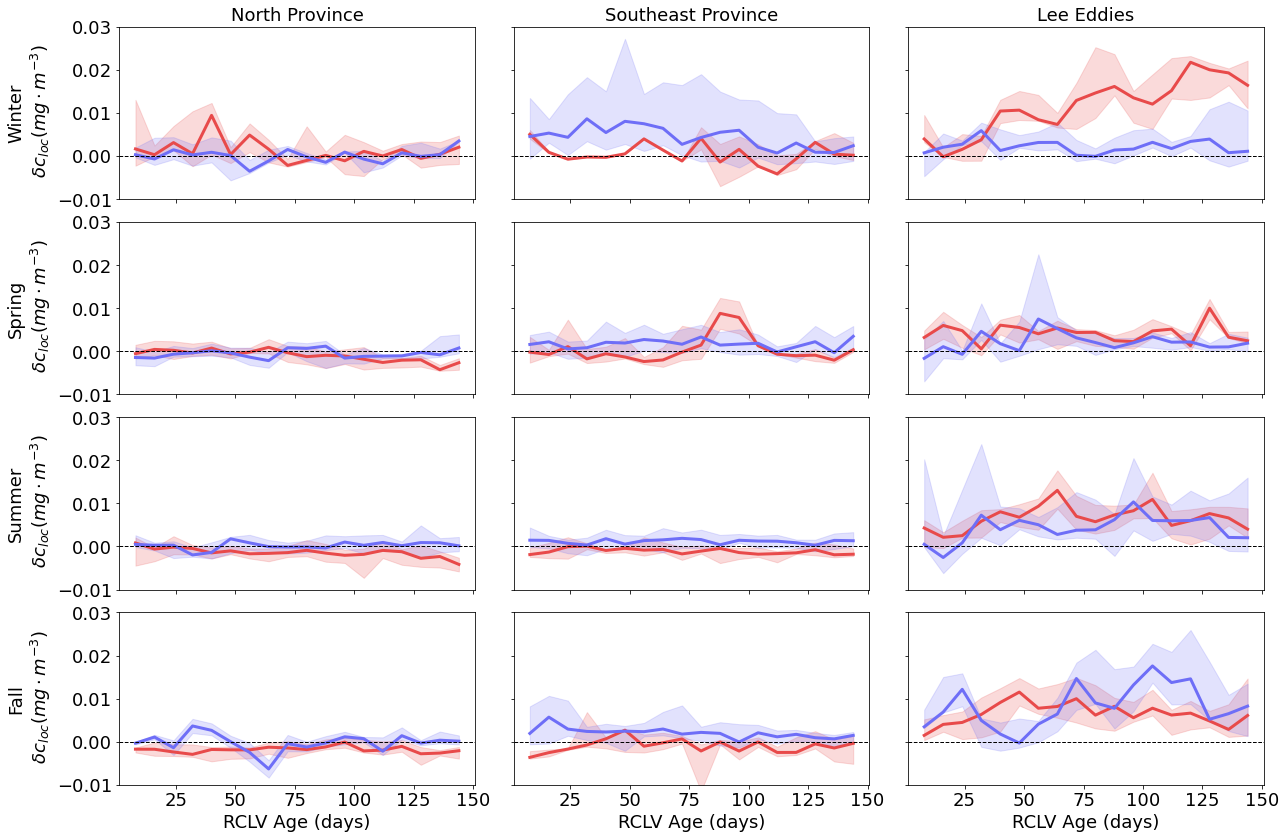

In [20]:
fontsize = 18
fig, ax = plt.subplots(4,3,figsize=(18,12))

anti_color = '#e84a4a'
cyc_color = '#6e6ef7'

s = 0
for season in ['WIN','SPR','SUM','FAL']:
    p = 0
    for province in ['1','0','2']:
        key = season + province        
        age_groups = np.arange(8,152,8)
        
        ########## ANTICYCLONES ############
        anti_med_chl_diffs_by_age,anti_q1_chl_diffs_by_age,anti_q3_chl_diffs_by_age = sort_by_age(anti_by_season_prov[key],age_groups)
        ax[s,p].plot(age_groups,anti_med_chl_diffs_by_age,linewidth=3,color=anti_color)
        ax[s,p].fill_between(age_groups,anti_q1_chl_diffs_by_age,anti_q3_chl_diffs_by_age,alpha=0.2,color=anti_color)
        
        ########## CYCLONES ############
        cyc_med_chl_diffs_by_age,cyc_q1_chl_diffs_by_age,cyc_q3_chl_diffs_by_age = sort_by_age(cyc_by_season_prov[key],age_groups)
        ax[s,p].plot(age_groups,cyc_med_chl_diffs_by_age,linewidth=3,color=cyc_color)
        ax[s,p].fill_between(age_groups,cyc_q1_chl_diffs_by_age,cyc_q3_chl_diffs_by_age,alpha=0.2,color=cyc_color)
        ax[s,p].axhline(0,linewidth=1,linestyle='--',c='k')
        ax[s,p].set_ylim([-0.01,0.03])
        ax[s,p].tick_params(axis='both',which='major',labelsize=fontsize)
        p += 1
    s += 1
        
ax[0,0].set_ylabel('Winter\n $\delta c_{loc} (mg\cdot m^{-3})$',fontsize=fontsize)
ax[1,0].set_ylabel('Spring\n $\delta c_{loc} (mg\cdot m^{-3})$',fontsize=fontsize)
ax[2,0].set_ylabel('Summer\n $\delta c_{loc} (mg\cdot m^{-3})$',fontsize=fontsize)
ax[3,0].set_ylabel('Fall\n $\delta c_{loc} (mg\cdot m^{-3})$',fontsize=fontsize)
    
ax[0,0].set_title('North Province',fontsize=fontsize)
ax[0,1].set_title('Southeast Province',fontsize=fontsize)
ax[0,2].set_title('Lee Eddies',fontsize=fontsize)
    
for i in np.arange(0,4):
    for j in np.arange(0,3):
        if (j != 0):
            ax[i,j].set_yticklabels([])
        if (i != 3):
            ax[i,j].set_xticklabels([])
        if (i == 3):
            ax[i,j].set_xlabel('RCLV Age (days)',fontsize=fontsize)
    
fig.tight_layout()
#plt.show()
save_dir = project_output_dir + 'RCLV_CHL_PAPER_FIGS/'
#plt.savefig(save_dir + 'cloc_RCLV_age_long_lived.png', format='png', dpi=350)

In [21]:
def plot_eddy_trajs(eddy_dict,track_color,legend):

    star_colors = []

    for ID in eddy_dict:
        ID_data = eddy_dict[ID] 

        #### Plot star colored by birth season ####
        month = int(ID_data[0][0][4:6]) 

        if (month == 12) or (month<=2): #winter
            color = 'b'
            label = 'Winter'
        elif (month > 2) and (month<=5): #spring
            color = 'g'
            label = 'Spring'
        elif (month > 5) and (month<=8): #summer
            color = 'orange'
            label = 'Summer'
        elif (month > 8) and (month<=11): #fall
            color = 'r'
            label = 'Fall'

        if color not in star_colors:
            ax.scatter(float(ID_data[0][5]),float(ID_data[0][6]),marker='*',s=1000,c=color,zorder=10,label=label)
            star_colors.append(color)
        else: # no label for the star
            ax.scatter(float(ID_data[0][5]),float(ID_data[0][6]),marker='*',s=1000,c=color,zorder=10)

        #### Plot eddy track #### 
        x_values,y_values = [],[]
        for r in ID_data:
            x_values.append(float(r[5]))
            y_values.append(float(r[6]))
        ax.scatter(float(ID_data[0][5]),float(ID_data[0][6]),s=50,edgecolor='k',c=track_color,zorder=11)
        ax.plot(x_values,y_values,c=track_color,linewidth=3)

    if legend == True:
        ax.legend(title='RCLV Genesis',title_fontsize=fontsize,fontsize=fontsize)

In [22]:
# Color codes
blues = ['#9e9efa','#6e6ef7','#3d3df5','#0d0df2','#0a0ac2']
reds = ['#ed7878','#e84a4a','#e21d1d','#b51717','#871212']

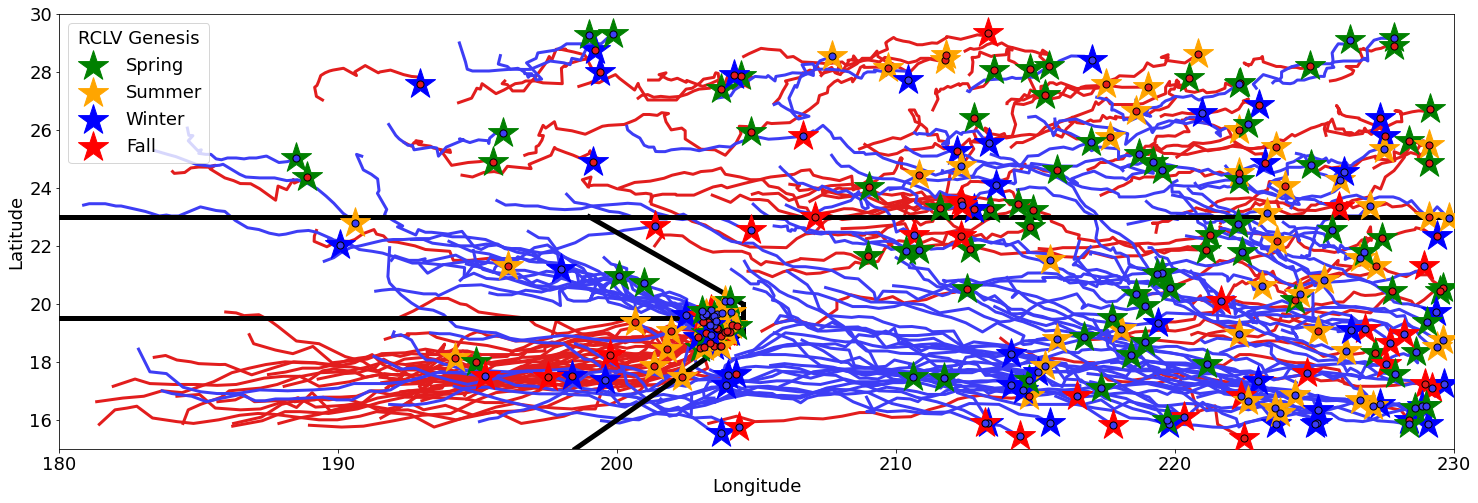

In [23]:
fontsize=18
fig,ax = plt.subplots(1,1,figsize=(25,8))

plot_eddy_trajs(anti_long_lived_sorted,reds[2],True)
plot_eddy_trajs(cyc_long_lived_sorted,blues[2],False)

ax.axhline(23,color='k',linewidth=5)
ax.axhline(19.5,xmax=0.49,color='k',linewidth=5)
ax.plot([199,204.5],[23,20],color='k',linewidth=5) # top of cyclones
ax.plot([198.5,204.5],[15,19],color='k',linewidth=5) # bottom of anticycs
ax.plot([204.5,204.5],[19,20],color='k',linewidth=5) # vertical line

#ax.set_title('150+ Day RCLVs',fontsize=fontsize)
ax.set_xlim([180,230])
ax.set_ylim([15,30])
ax.tick_params(axis='both',which='major',labelsize=fontsize)
ax.set_xlabel('Longitude',fontsize=fontsize)
ax.set_ylabel('Latitude',fontsize=fontsize)

#plt.show()

save_dir = project_output_dir + 'RCLV_CHL_PAPER_FIGS/'
#plt.savefig(save_dir + 'long_lived_RCLV_translation_pathways.png', format='png', dpi=350)

### Pull it together

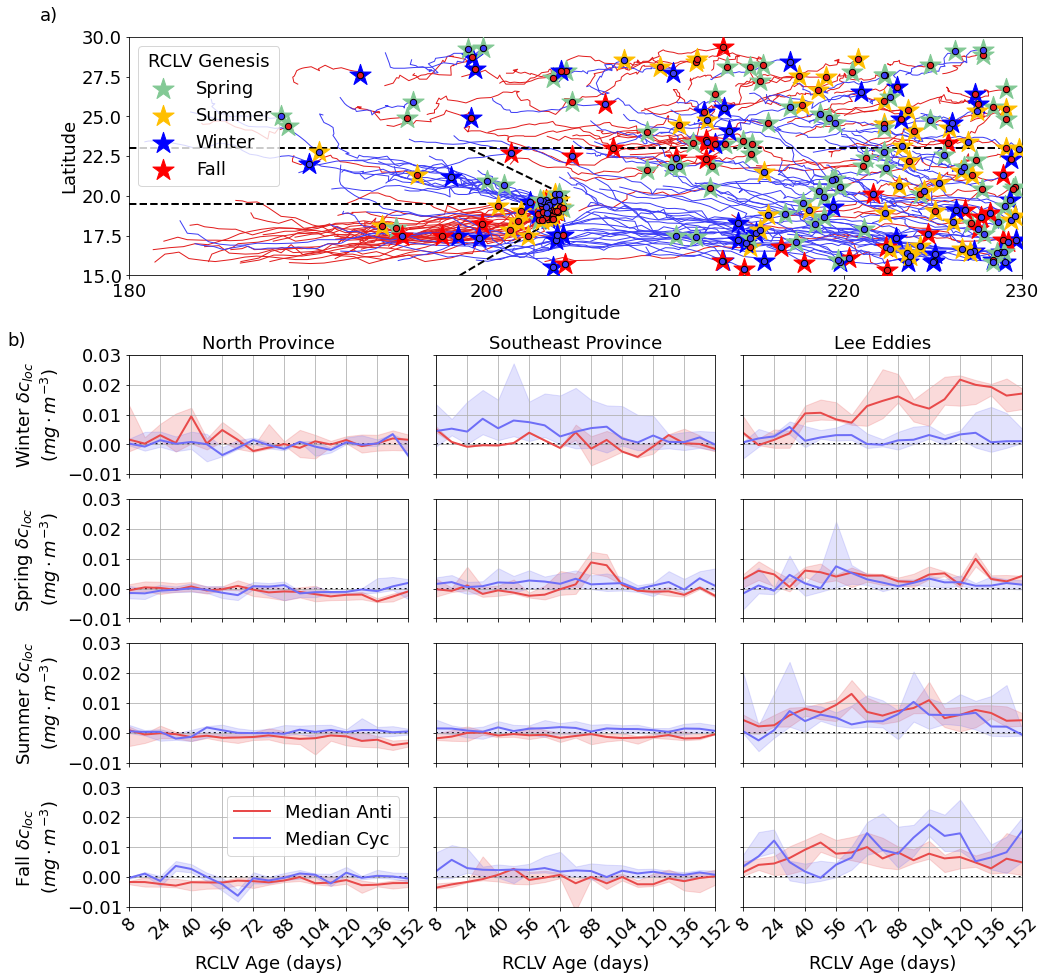

In [24]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_gridspec(6,3,height_ratios=[2,0.25,1,1,1,1],wspace=0.1,hspace=0.2)
ax_traj = fig.add_subplot(ax[0,:])

# add an invisible buffer axis between trajectories and other plots
ax_buff = fig.add_subplot(ax[1,:])
ax_buff.set_visible(False)

linewidth = 2

################################################## TRAJ PLOT ##################################################

for eddy_dict in [anti_long_lived_sorted,cyc_long_lived_sorted]:
    
    star_colors = []
    for ID in eddy_dict:
        ID_data = eddy_dict[ID] 

        #### Plot star colored by birth season ####
        month = int(ID_data[0][0][4:6]) 

        if (month == 12) or (month<=2): #winter
            color = 'b'  
            label = 'Winter'
        elif (month > 2) and (month<=5): #spring
            color = '#83c995' #'g'
            label = 'Spring'
        elif (month > 5) and (month<=8): #summer
            color = '#ffbf00' #'orange'
            label = 'Summer'
        elif (month > 8) and (month<=11): #fall
            color = 'r'
            label = 'Fall'

        if color not in star_colors:
            ax_traj.scatter(float(ID_data[0][5]),float(ID_data[0][6]),marker='*',s=500,c=color,zorder=10,label=label)
            star_colors.append(color)
        else: # no label for the star
            ax_traj.scatter(float(ID_data[0][5]),float(ID_data[0][6]),marker='*',s=500,c=color,zorder=10)

        #### Plot eddy track #### 
        if eddy_dict == anti_long_lived_sorted:
            track_color = '#e21d1d'
        elif eddy_dict == cyc_long_lived_sorted:
            track_color = '#3d3df5'
            
        x_values,y_values = [],[]
        for r in ID_data:
            x_values.append(float(r[5]))
            y_values.append(float(r[6]))
        ax_traj.scatter(float(ID_data[0][5]),float(ID_data[0][6]),s=40,edgecolor='k',c=track_color,zorder=11)
        ax_traj.plot(x_values,y_values,c=track_color,linewidth=linewidth-1)

    if eddy_dict == anti_long_lived_sorted:
        ax_traj.legend(title='RCLV Genesis')

ax_traj.axhline(23,color='k',linewidth=linewidth,linestyle='--')
ax_traj.axhline(19.5,xmax=0.49,color='k',linewidth=linewidth,linestyle='--')
ax_traj.plot([199,204.5],[23,20],color='k',linewidth=linewidth,linestyle='--') # top of cyclones
ax_traj.plot([198.5,204.5],[15,19],color='k',linewidth=linewidth,linestyle='--') # bottom of anticycs
ax_traj.plot([204.5,204.5],[19,20],color='k',linewidth=linewidth,linestyle='--') # vertical line

ax_traj.set_xlim([180,230])
ax_traj.set_ylim([15,30])
ax_traj.set_xlabel('Longitude')
ax_traj.set_ylabel('Latitude')
ax_traj.text(175,31,'a)')
    
################################################## CHL DATA ##################################################

s = 2
for season in ['WIN','SPR','SUM','FAL']:
    p = 0
    for province in ['1','0','2']:
        curr_ax = fig.add_subplot(ax[s,p])
        
        
        key = season + province        
        age_groups = np.arange(8,152+8,8)
        
        ########## ANTICYCLONES ############
        anti_med_chl_diffs_by_age,anti_q1_chl_diffs_by_age,anti_q3_chl_diffs_by_age = sort_by_age(anti_by_season_prov[key],age_groups)
        curr_ax.plot(age_groups,anti_med_chl_diffs_by_age,linewidth=linewidth,color=anti_color,label='Median Anti')
        curr_ax.fill_between(age_groups,anti_q1_chl_diffs_by_age,anti_q3_chl_diffs_by_age,alpha=0.2,color=anti_color)
        
        ########## CYCLONES ############
        cyc_med_chl_diffs_by_age,cyc_q1_chl_diffs_by_age,cyc_q3_chl_diffs_by_age = sort_by_age(cyc_by_season_prov[key],age_groups)
        curr_ax.plot(age_groups,cyc_med_chl_diffs_by_age,linewidth=linewidth,color=cyc_color,label='Median Cyc')
        curr_ax.fill_between(age_groups,cyc_q1_chl_diffs_by_age,cyc_q3_chl_diffs_by_age,alpha=0.2,color=cyc_color)
        
        curr_ax.axhline(0,linewidth=linewidth,linestyle=':',c='k',zorder=0)
        
        # Grid params
        curr_ax.set_ylim([-0.01,0.03])
        curr_ax.set_yticks(np.arange(-0.01,0.04,0.01))
        
        curr_ax.set_xlim([8,152])
        curr_ax.set_xticks(age_groups[::2])
        curr_ax.set_xticklabels(age_groups[::2],rotation=45)
        curr_ax.grid(True)
        
        if (s==2) & (p==0):
            curr_ax.set_ylabel('Winter $\delta c_{loc}$ \n$(mg\cdot m^{-3})$')
            curr_ax.set_title('North Province')
            curr_ax.text(-55,0.033,'b)')
        elif (s==3) & (p==0):
            curr_ax.set_ylabel('Spring $\delta c_{loc}$ \n$(mg\cdot m^{-3})$')
        elif (s==4) & (p==0):
            curr_ax.set_ylabel('Summer $\delta c_{loc}$ \n$(mg\cdot m^{-3})$')
        elif (s==5) & (p==0):
            curr_ax.set_ylabel('Fall $\delta c_{loc}$ \n$(mg\cdot m^{-3})$')
        
        if (s==2) & (p==1):
            curr_ax.set_title('Southeast Province')
        elif (s==2) & (p==2):
            curr_ax.set_title('Lee Eddies')
            
        if (s==5):
            curr_ax.set_xlabel('RCLV Age (days)')
            if (p==0):
                curr_ax.legend()
        else:
            curr_ax.set_xticklabels([])
            
        if (p!= 0):
            curr_ax.set_yticklabels([])
            
        p += 1
    s += 1
    
save_dir = project_output_dir + 'RCLV_CHL_PAPER_FIGS/'
#plt.savefig(save_dir + 'long_lived_RCLV_chl_OS_r1.png', format='png', dpi=350)